# Overview

# Business Understanding

# Data Understanding

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


In [2]:
# Import NYPD crime data and preview the first 5 rows to ensure it was imported correctly
data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')
data.head()

/var/folders/pn/v9tvzf9s5ms7zcp53821ct0m0000gn/T/ipykernel_27540/800487650.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,25640826H10611,12/05/2006,10:38:00,NaN,(null),NaN,12/05/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO QUEENS NORTH,(null),25-44,WHITE HISPANIC,M
1,16631501H8965,08/25/1973,12:15:00,NaN,(null),NaN,05/29/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO MAN NORTH,(null),45-64,BLACK,F
2,11118212H8714,04/22/2006,16:50:00,NaN,(null),NaN,04/22/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),45-64,BLACK,M
3,23471265H9399,07/20/2006,22:37:00,NaN,(null),NaN,07/20/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,M
4,24565927H10142,04/14/2006,02:37:00,NaN,(null),NaN,04/14/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN NORTH,(null),45-64,BLACK,M


# Data Preparation

## Exploratory Data Analysis

In [64]:
# View the overall shape, dtypes and null counts for each column in train data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914838 entries, 0 to 8914837
Data columns (total 35 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CMPLNT_NUM         object 
 1   CMPLNT_FR_DT       object 
 2   CMPLNT_FR_TM       object 
 3   CMPLNT_TO_DT       object 
 4   CMPLNT_TO_TM       object 
 5   ADDR_PCT_CD        float64
 6   RPT_DT             object 
 7   KY_CD              int64  
 8   OFNS_DESC          object 
 9   PD_CD              float64
 10  PD_DESC            object 
 11  CRM_ATPT_CPTD_CD   object 
 12  LAW_CAT_CD         object 
 13  BORO_NM            object 
 14  LOC_OF_OCCUR_DESC  object 
 15  PREM_TYP_DESC      object 
 16  JURIS_DESC         object 
 17  JURISDICTION_CODE  int64  
 18  PARKS_NM           object 
 19  HADEVELOPT         object 
 20  HOUSING_PSA        object 
 21  X_COORD_CD         float64
 22  Y_COORD_CD         float64
 23  SUSP_AGE_GROUP     object 
 24  SUSP_RACE          object 
 25  SUSP_SEX          

In [13]:
# Convert 'CMPLNT_NUM' to string
data['CMPLNT_NUM'] = data['CMPLNT_NUM'].astype(str)

In [15]:
# Check for duplicated using 'CMPLNT_NUM'
data['CMPLNT_NUM'].duplicated().value_counts()

CMPLNT_NUM
False    8913734
True        1104
Name: count, dtype: int64

In [20]:
data[data['CMPLNT_NUM'].duplicated() == True].sort_values('CMPLNT_NUM', axis=0)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
92052,10012321,01/03/2006,22:00:00,NaN,(null),62.0,01/03/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.614331,-73.979106,"(40.614331, -73.979106)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
337659,10012366,12/23/2005,10:30:00,NaN,(null),63.0,01/03/2006,109,GRAND LARCENY,415.0,...,(null),NaN,40.627544,-73.937954,"(40.627544, -73.937954)",PATROL BORO BKLYN SOUTH,(null),65+,BLACK,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239715,9966585,01/02/2005,16:30:00,NaN,(null),70.0,01/02/2006,109,GRAND LARCENY,421.0,...,(null),NaN,40.642402,-73.959552,"(40.642402, -73.959552)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,F
124876,9966658,01/04/2006,15:30:00,01/05/2006,09:30:00,72.0,01/05/2006,341,PETIT LARCENY,321.0,...,(null),NaN,40.661648,-73.981201,"(40.661648, -73.981201)",PATROL BORO BKLYN SOUTH,(null),45-64,WHITE,M
378931,9966757,12/15/2005,11:00:00,NaN,(null),75.0,01/03/2006,353,UNAUTHORIZED USE OF A VEHICLE,462.0,...,M,NaN,40.671360,-73.881811,"(40.6713598203364, -73.8818110231735)",PATROL BORO BKLYN NORTH,(null),18-24,BLACK,F
48564,9966791,01/04/2006,08:55:00,01/04/2006,09:00:00,76.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,(null),NaN,40.683651,-74.000304,"(40.6836512406856, -74.0003043120176)",PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,F


In [16]:
data[data['CMPLNT_NUM'].duplicated() == True].sort_values('CMPLNT_NUM').head(20)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
92052,10012321,01/03/2006,22:00:00,NaN,(null),62.0,01/03/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.614331,-73.979106,"(40.614331, -73.979106)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
337659,10012366,12/23/2005,10:30:00,NaN,(null),63.0,01/03/2006,109,GRAND LARCENY,415.0,...,(null),NaN,40.627544,-73.937954,"(40.627544, -73.937954)",PATROL BORO BKLYN SOUTH,(null),65+,BLACK,F
515607,10015119,01/05/2006,20:30:00,01/07/2006,02:00:00,45.0,01/07/2006,107,BURGLARY,224.0,...,(null),NaN,40.824741,-73.821517,"(40.824741, -73.821517)",PATROL BORO BRONX,(null),25-44,WHITE HISPANIC,F
358705,10015262,01/04/2006,16:48:00,01/04/2006,16:48:00,49.0,01/04/2006,236,DANGEROUS WEAPONS,782.0,...,(null),NaN,40.856577,-73.843894,"(40.8565767275976, -73.8438936779283)",PATROL BORO BRONX,(null),(null),UNKNOWN,E
467185,10015321,01/03/2006,18:00:00,01/03/2006,19:00:00,50.0,01/03/2006,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,M,NaN,40.882862,-73.903574,"(40.8828621313214, -73.9035744897024)",PATROL BORO BRONX,(null),65+,WHITE,F
489184,10015453,01/07/2006,21:46:00,01/07/2006,21:56:00,115.0,01/07/2006,113,FORGERY,723.0,...,(null),NaN,40.756568,-73.875932,"(40.7565675846374, -73.8759315341335)",PATROL BORO QUEENS NORTH,(null),(null),UNKNOWN,E
467859,10016512,01/04/2006,10:00:00,01/04/2006,23:00:00,113.0,01/05/2006,110,GRAND LARCENY OF MOTOR VEHICLE,441.0,...,(null),NaN,40.674323,-73.789208,"(40.674323, -73.789208)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,F


In [29]:
data['LAW_CAT_CD'].value_counts().index[1]

'FELONY'

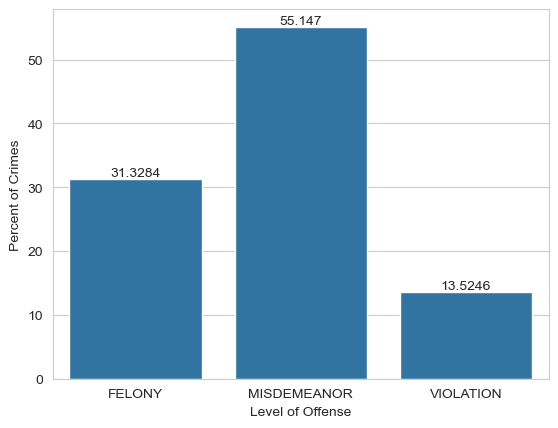

In [44]:
# Visualize crimes by level of offense
ax = sns.countplot(x="LAW_CAT_CD", data=data, stat='percent')
ax.set_xlabel('Level of Offense')
ax.set_ylabel('Percent of Crimes')
ax.
ax.bar_label(ax.containers[0]);

In [38]:
data['LAW_CAT_CD'].value_counts(normalize=True)

LAW_CAT_CD
MISDEMEANOR    0.551470
FELONY         0.313284
VIOLATION      0.135246
Name: proportion, dtype: float64

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8914838,) and arg 1 with shape (3,).

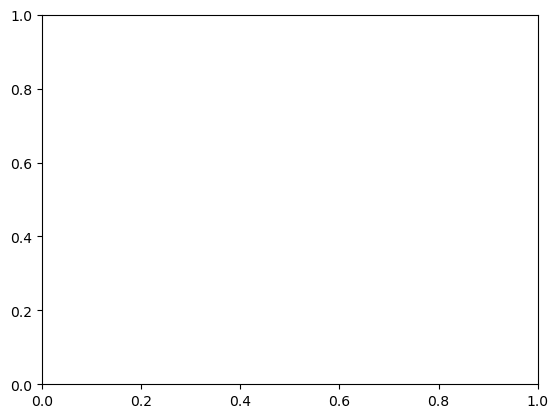

In [30]:
# Visualize crimes by level of offense
plt.bar(x=data['LAW_CAT_CD'].index, height=data['LAW_CAT_CD'].value_counts())

## Data Preparation

## Feature Engineering

# Modeling

## Baseline Model

## Modeline Iterations

## Final Model

# Conclusion

## Limitations

## Next Steps